<a id='intro'></a>
## Simulation of a Single Spectrum

We will simulate the energy spectrum of 3FHL J1230.8+1223 from the Fermi-LAT 3FHL source catalog considering the Dominguez EBL absorption spectral model. To do a simulation, we need to define the observational parameters like
the livetime, the offset, the assumed integration radius, the energy
range to perform the simulation for and the choice of spectral model. We
then use an in-memory observation which is convolved with the IRFs to
get the predicted number of counts. This is Poission fluctuated using
the `fake()` to get the simulated counts for each observation.

<a id='indice'></a>
### Indice
[Step 0.0:  Setting the Engine Tools](#step0)<br>
$\;\;\;\;\;$[Step 0.1:  Importing the Python Necessary Tools](#step0.1)<br>
$\;\;\;\;\;$[Step 0.2:  Defining Functions](#step0.2)<br>
[Step 1.0: Source Information](#step1)<br>
[Step 2.0: Creates the Observation](#step2)<br>
[Step 3.0: Defining the Skymodel](#step3)<br>
[Step 4.0: Simulating the Spectrum](#step4)<br>
$\;\;\;\;\;$[Step 4.1: Defines the geometry](#step4.1)<br> 
$\;\;\;\;\;$[Step 4.2: Setting the Model on the Dataset](#step4.2)<br> 
[Step 5.0: On-Off Analysis](#step5)<br>
$\;\;\;\;\;$[Step 5.1: Simulating the Observations](#step5.1)<br>
$\;\;\;\;\;$[Step 5.2: Plotting Counts, Excess and Significance](#step5.2)<br>
$\;\;\;\;\;$[Step 5.3: Computing the Sensitivity](#step5.3)<br>
$\;\;\;\;\;$[Step 5.4 Computing the Flux Points](#step5.4)<br>

<a id='step0'></a>
## Step 0.0:  Setting the Engine Tools

<a id='step0.1'></a>
### Step 0.1: Importing the Python Necessary Tools

In [1]:
import gammapy
from astropy import units as u
import numpy as np
from astropy.io import ascii
import collections
import sys, os
import matplotlib.pyplot as plt

from gammapy.catalog import SourceCatalog3FHL
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, Observations, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.irf import load_cta_irfs
from gammapy.maps import MapAxis, RegionGeom

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.irf import EffectiveAreaTable2D

from numpy.random import RandomState

from scipy.stats import chi2, norm

from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset

# astropy imports
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column

from gammapy.estimators import SensitivityEstimator

# astropy affiliated packages imports
from regions import CircleSkyRegion

from gammapy.stats import WStatCountsStatistic
from gammapy.stats import CashCountsStatistic
from scipy.stats import sem
from gammapy.maps import Map
from regions import PointSkyRegion

import math

from pathlib import Path

<a id='step0.2'></a>
### Step 0.2: Defining Functions

In [2]:
def mkdir_base_child(base_dir, child_dir):
    '''Creates a directory: base_dir/child_dir and returs the path 
    mkdir_base_child(base_dir, child_dir)
    >>> path_child
    '''
    path_base = Path(f"{base_dir}")
    path_base.mkdir(exist_ok=True)

    path_child = Path(f"{path_base}/{child_dir}")
    path_child.mkdir(exist_ok=True)
    
    return path_child

In [3]:
def plt_savefig(path_child, child_name):
    ''' Saves figures (.png and .pdf) in the path_child directoty    
    plt_savefig(path_child, child_name)
    >>> plt.savefig(file, bbox_inches='tight')
    '''
    formats_file = [".png", ".pdf"]
    for format_file in formats_file: 
        file = path_child / f'{src_id}_{child_name}_{ebl_ref}{format_file}'
        plt.savefig(file, bbox_inches='tight')


___

🔝 [Back to Top](#intro)<br>

<a id='step1'></a>
## Step 1.0:  Source Information

In [4]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance

In [5]:
cosmology.default_cosmology.set(WMAP7)
cosmology.default_cosmology.get()

FlatLambdaCDM(name="WMAP7", H0=70.4 km / (Mpc s), Om0=0.272, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0455)

[source](https://docs.astropy.org/en/stable/api/astropy.cosmology.FlatLambdaCDM.html#astropy.cosmology.FlatLambdaCDM)
+ H0 = Hubble constant at z = 0. If a float, must be in [km/sec/Mpc].
Om0 = Omega matter: density of non-relativistic matter in units of the critical density at z=0.
+ Tcmb0 = Temperature of the CMB z=0. If a float, must be in [K]. Default: 0 [K]. Setting  this to zero will turn off both photons and neutrinos (even massive ones).
+ Neff = Effective number of Neutrino species. Default 3.04.
+ m_nu = Mass of each neutrino species in [eV] (mass-energy equivalency enabled). If this is a scalar Quantity, then all neutrino species are assumed to have that mass. Otherwise, the mass of each species. The actual number of neutrino species (and hence the number of elements of m_nu if it is not scalar) must be the floor of Neff. Typically this means you should provide three neutrino masses unless you are considering something like a sterile neutrino.
+ Ob0 = Omega baryons: density of baryonic matter in units of the critical density at z=0. If this is set to None (the default), any computation that requires its value will raise an exception.



In [6]:
src_name = "PSR J1826-1334"  # Official source name 3FHL JHHMM.m+DDMM
src_id  = src_name.replace(" ", "") # Name of identified or likely associated source

[ATNF Pulsar Catalogue: PSR J1826-1334](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.69&Name=Name&JName=JName&RaJ=RaJ&DecJ=DecJ&Dist=Dist&Dist_DM=Dist_DM&Assoc=Assoc&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J1826-1334&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=50&table_bottom.y=14)

In [7]:
src_dist = Distance(value = 3.606, unit = u.kpc) # The source distance.
src_red = float(src_dist.compute_z()) # The source redshift for this distance assuming its physical distance is a luminosity distance.
src_dist, src_red

(<Distance 3.606 kpc>, 8.467890787929234e-07)

In [8]:
src_dist.compute_z()

<Quantity 8.46789079e-07 redshift>

In [9]:
# src_red = float(src_red) # Redshift of counterpart, if known

In [10]:
src_ra =Angle('18h26m13.175s').degree   
src_de  = Angle("-13d34m46.8s").degree   # Declination (deg)

In [11]:
print(f"{src_id} Source Information:")
print(f"(RAJ2000, DEJ2000) = ({src_ra:.3f}, {src_de:.3f}); Redshift = {src_red:.8f}" )

PSRJ1826-1334 Source Information:
(RAJ2000, DEJ2000) = (276.555, -13.580); Redshift = 0.00000085


___

🔝 [Back to Top](#intro)<br>

<a id='step2'></a>
## Step 2.0:  Creates the Observation

Define the source position:

In [12]:
frame  = "icrs" # International Celestial Reference System (ICRS)
unit   = "deg"  # Degrees units

In [13]:
src_pos = SkyCoord(src_ra, src_de, unit=unit, frame=frame) # Source Position

Define the observation parameters (typically the observation duration and the pointing position):


In [14]:
livetime = 5 * u.h # Livetime exposure of the simulated observation

offset = 0.11 * u.deg # Pointing position  offset
pointing = SkyCoord(src_pos.ra, src_pos.dec + offset, unit=unit, frame=frame)
# print(pointing)

Load the IRFs:

'/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf/South_z20_N_5h/irf_file.fits'

In [48]:
# In this simulation, we use the CTA-1DC irfs shipped with gammapy
base_name = '/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf'
irf_name = 'South_z20_N_5h/irf_file'
format_dat = '.fits'
irfs = load_cta_irfs(f"{base_name}/{irf_name}{format_dat}")

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Creates a observation:

In [16]:
location = observatory_locations["cta_north"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.21
	duration          : 18000.00 s
	pointing (icrs)   : 276.6 deg, -13.5 deg

	deadtime fraction : 0.0%



In [17]:
help(obs)

Help on Observation in module gammapy.data.observations object:

class Observation(builtins.object)
 |  Observation(obs_id=None, obs_info=None, gti=None, aeff=None, edisp=None, psf=None, bkg=None, rad_max=None, events=None, obs_filter=None)
 |  
 |  In-memory observation.
 |  
 |  Parameters
 |  ----------
 |  obs_id : int
 |      Observation id
 |  obs_info : dict
 |      Observation info dict
 |  aeff : `~gammapy.irf.EffectiveAreaTable2D`
 |      Effective area
 |  edisp : `~gammapy.irf.EnergyDispersion2D`
 |      Energy dispersion
 |  psf : `~gammapy.irf.PSF3D`
 |      Point spread function
 |  bkg : `~gammapy.irf.Background3D`
 |      Background rate model
 |  rad_max: `~gammapy.irf.RadMax2D`
 |      Only for point-like IRFs: RAD_MAX table (energy dependent RAD_MAX)
 |      For a fixed RAD_MAX, create a RadMax2D with a single bin.
 |  gti : `~gammapy.data.GTI`
 |      Table with GTI start and stop time
 |  events : `~gammapy.data.EventList`
 |      Event list
 |  obs_filter : `Obse

___

🔝 [Back to Top](#intro)<br>

<a id='step3'></a>
## Step 3.0:  Defining the Skymodel
Define spectral model:

In [18]:
# A simple Power Law
index=2.24
amplitude=6.47e-13 * u.Unit("cm-2 s-1 TeV-1")
reference=0.1 * u.TeV
    
pwl = PowerLawSpectralModel(
    index=index,
    amplitude=amplitude,
    reference=reference,
)
# print(pwl)

Define absorption model:

In [19]:
ebl_models = ['franceschini', 'dominguez', 'finke'] # Available models in gammapy-data:{'franceschini', 'dominguez', 'finke'}

ebl_ref = ebl_models[1] # dominguez

absorption = EBLAbsorptionNormSpectralModel.read_builtin(
    reference = ebl_ref, 
    redshift=src_red
)
print(absorption)

EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 8.4679e-07      0.000e+00 nan nan   True   False     


The compound spectral model:

In [20]:
absspecmodel = pwl * absorption # CompoundSpectralModel
print(absspecmodel)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.2400e+00                ... nan  False   False     
spectral amplitude 6.4700e-13 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e-01            TeV ... nan   True   False     
    Component 2 : EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 8.4679e-07      0.000e+00 nan nan   True   False     
    Operator : mul



Setting the sky model used in the dataset:

In [21]:
skymodel = SkyModel(
    spectral_model=absspecmodel, 
    name="model_simu"
)
print(skymodel)

SkyModel

  Name                      : model_simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.240   +/-    0.00             
    amplitude                     :   6.47e-13   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      0.100       TeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   




___

🔝 [Back to Top](#intro)<br>

<a id='step4'></a>
## Step 4.0:  Simulating the Spectrum
<a id='step4.1'></a>
### Step 4.1: Defines the geometry

In [22]:
# Defines the energy range
emin = 25 * u.GeV   # Minimum energy
emax = 100. * u.TeV # Maximum energy

In [23]:
# Reconstructed energy axis
energy_reco = MapAxis.from_energy_bounds(
    emin, 
    emax, 
    nbin=5, 
    per_decade=True, 
    name="energy"
)
# print(energy_reco)

In [24]:
# Defines the on region:
on_region_radius = Angle("0.11 deg")

on_region = CircleSkyRegion(
    center=src_pos, 
    radius=on_region_radius
)
print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (276.55489583, -13.57966667)>
radius: 0.11 deg


In [25]:
#Defines the geometry:
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_reco]
)

<a id='step4.2'></a>
### Step 4.2: Setting the Model on the Dataset

In [26]:
# Defines the true energy axis:
# true energy axis should be wider than reco energy axis
energy_true = MapAxis.from_energy_bounds(
    0.3*emin, 
    3*emax, 
    nbin=8, 
    per_decade=True, 
    name="energy_true"
)
# print(energy_true)

In [27]:
# Create a MapDataset object with zero filled maps.
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_true,
    name="obs-0"
)

In [28]:
# Make spectrum for a single IACT observation:
# The irfs and background are computed at a single fixed offset, which is recommended only for point-sources.
maker = SpectrumDatasetMaker(
    containment_correction=True, # Apply containment correction for point sources and circular on regions.
    selection=["edisp", "background", "exposure"] # Selecting which maps to make
)
safe_maker = SafeMaskMaker(methods=["bkg-peak"]) # Make safe data range mask for a given observation.

In [29]:
# Make map dataset:
dataset = maker.run(dataset_empty, obs) 
dataset = safe_maker.run(dataset, obs)

In [30]:
# Set the model on the dataset, and fake
dataset.models = skymodel
dataset.fake(random_state=42)
# print(dataset)

You can see that background counts are now simulated.

___

🔝 [Back to Top](#intro)<br>

<a id='step5'></a>
### Step 5.0: On-Off Analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts

<a id='step5.1'></a>
### Step 5.1: Simulating the Observations

In [31]:
# Spectrum dataset for on-off likelihood fitting.
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, 
    acceptance=1, 
    acceptance_off=5
)

# Simulate fake counts (on and off) for the current model and reduced IRFs.
dataset_onoff.fake(
    random_state='random-seed', 
    npred_background=dataset.npred_background()
)

# print(dataset_onoff)

In [32]:
# Class to compute statistics for Poisson distributed variable with unknown background.
significance = WStatCountsStatistic(
    n_on=sum(dataset_onoff.counts.data), 
    n_off=sum(dataset_onoff.counts_off.data), 
    alpha=0.2).sqrt_ts
# print(significance)

In [33]:
n_obs = 10 # We simulate each observation n_obs times, to randomize the renortets

In [34]:
datasets = Datasets()

for idx in range(n_obs):
    dataset_onoff.fake(
        random_state=idx, 
        npred_background=dataset.npred_background()
    )
    dataset_fake = dataset_onoff.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
# print(table)

<a id='step5.2'></a>
### Step 5.2: Plotting Counts, Excess and Significance

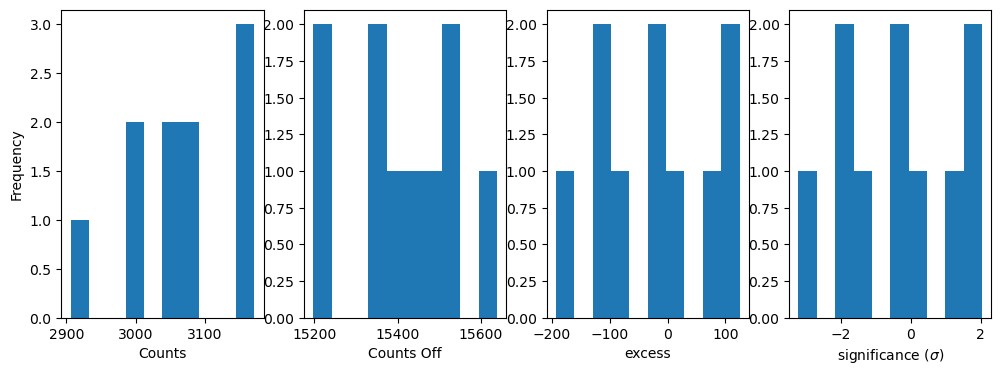

In [35]:
fix, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Frequency");

axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off");

axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

axes[3].hist(table["sqrt_ts"])
axes[3].set_xlabel(r"significance ($\sigma$)");

path_counts = mkdir_base_child("analysis", "counts")

plt_savefig(path_counts, "counts")

<a id='step5.3'></a>
### Step 5.3: Computing the Sensitivity

  energy      e2dnde     excess background  criterion  
   TeV    erg / (cm2 s)                                
--------- ------------- ------- ---------- ------------
0.0310979    1.1426e-11  107.76     1033.8 significance
0.0481186   5.83115e-12 89.1909      702.4 significance
0.0744552   2.14166e-12 75.1498      494.2 significance
 0.115207   1.10143e-12 64.9456      365.8 significance
 0.178262   9.57585e-13 50.0291      212.8 significance
  0.27583   4.80795e-13 36.1113      107.2 significance
      ...           ...     ...        ...          ...
  5.85755   2.38898e-13 8.79436        4.2 significance
  9.06355   2.57193e-13 6.70497          2 significance
  14.0243   4.54157e-13 6.21488        1.6 significance
  21.7001   5.03564e-13 6.21488        1.6 significance
  33.5772   6.05582e-13       5          0        gamma
  51.9549    9.3197e-13       5        0.4        gamma
  80.3913   1.81272e-12       5          0        gamma
Length = 19 rows


FileNotFoundError: [Errno 2] No such file or directory: 'analysis/sensitivity/PSRJ1826-1334_sensitivity_South_z20_N_5h/irf_file_PSRJ1826-1334_dominguez.png'

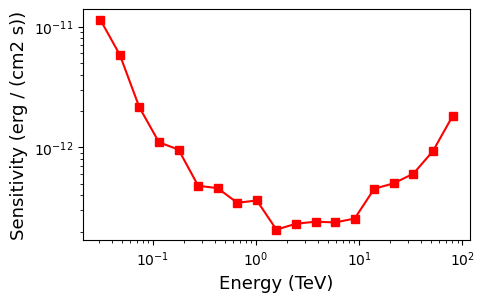

In [49]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, 
    n_sigma=3, 
    bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_onoff)
print(sensitivity_table)

# Plot the sensitivity curve
t = sensitivity_table

fix, axes = plt.subplots(figsize=(5, 3))

axes.plot(t["energy"], t["e2dnde"], "s-", color="red")
axes.loglog()

axes.set_xlabel(f"Energy ({t['energy'].unit})", size=13)
axes.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})", size=13)

path_sens = mkdir_base_child("analysis", "sensitivity")

plt_savefig(path_sens, f'sensitivity_{irf_name}_{src_id}')

In [37]:
help(SensitivityEstimator)

Help on class SensitivityEstimator in module gammapy.estimators.points.sensitivity:

class SensitivityEstimator(gammapy.estimators.core.Estimator)
 |  SensitivityEstimator(spectrum=None, n_sigma=5.0, gamma_min=10, bkg_syst_fraction=0.05)
 |  
 |  Estimate differential sensitivity.
 |  
 |  This class allows to determine for each reconstructed energy bin the flux
 |  associated to the number of gamma-ray events for which the significance is
 |  ``n_sigma``, and being larger than ``gamma_min`` and ``bkg_sys`` percent
 |  larger than the number of background events in the ON region.
 |  
 |  
 |  Parameters
 |  ----------
 |  spectrum : `SpectralModel`
 |      Spectral model assumption
 |  n_sigma : float, optional
 |      Minimum significance. Default is 5.
 |  gamma_min : float, optional
 |      Minimum number of gamma-rays. Default is 10.
 |  bkg_syst_fraction : float, optional
 |      Fraction of background counts above which the number of gamma-rays is. Default is 0.05
 |  
 |  Examp

<a id='step5.4'></a>
### Step 5.4:  Computing the Flux Points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [38]:
#Compute flux points
datasets.models = [skymodel]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = skymodel.copy()

energy_edges = MapAxis.from_energy_bounds("0.1 TeV", "30 TeV", nbin=12).edges

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="model_simu", selection_optional="all")
flux_points = fpe.run(datasets=datasets)

display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.115,0.093,0.143,-5.964e-18,-2.528e-14,nan,nan,nan,0.000,0.001,369.9999939043833 .. 365.99999386793877,-7.362497e-06 .. -7.362497e-06,14.292,True,382.0 .. 367.0,True,0.200 .. 5.000,14.292 .. 14.292
0.178,0.143,0.222,-2.097e-20,-1.555e-15,nan,nan,nan,-0.000,0.000,208.99999995440498 .. 212.99999995436042,-5.4818997e-08 .. -5.4818997e-08,13.936,True,211.0 .. 214.0,True,0.200 .. 5.000,13.936 .. 13.936
0.276,0.222,0.343,3.638e-13,-1.053e-20,nan,nan,nan,0.852,-0.923,115.63180629935741 .. 115.9983952051841,3.3603075 .. 3.3603075,10.579,True,116.0 .. 144.0,True,0.200 .. 5.000,11.430 .. 11.430
0.531,0.343,0.821,2.942e-14,-2.228e-21,nan,nan,nan,0.240,-0.490,86.42486788177573 .. 88.93006143264921,1.5358417 .. 1.5358417,18.407,True,94.0 .. 91.0,True,0.200 .. 5.000,18.647 .. 18.647
1.022,0.821,1.271,-3.333e-22,-5.962e-17,nan,nan,nan,0.000,0.000,13.33333331253238 .. 15.499999980367084,-2.3112172e-08 .. -2.3112172e-08,7.804,True,8.0 .. 14.0,True,0.200 .. 5.000,7.804 .. 7.804
1.581,1.271,1.967,4.126e-15,-1.674e-22,nan,nan,nan,0.660,-0.812,10.406584035076929 .. 8.681971320075663,0.8645304 .. 0.8645304,10.120,True,9.0 .. 11.0,True,0.200 .. 5.000,10.780 .. 10.780
2.447,1.967,3.043,-3.120e-15,-5.944e-23,-1.957e-15,-1.957e-15,nan,2.453,1.566,5.980923972108203 .. 4.719603147162841,-1.3777002 .. -1.3777002,20.899,True,5.0 .. 2.0,True,0.200 .. 5.000,23.352 .. 23.352
3.786,3.043,4.709,-3.782e-16,-2.111e-23,nan,nan,nan,0.182,0.426,4.030259452785136 .. 4.057222894092407,-0.33040053 .. -0.33040053,10.036,True,2.0 .. 4.0,True,0.200 .. 5.000,10.218 .. 10.218


In [39]:
xerr

NameError: name 'xerr' is not defined

In [ ]:
e_ref = []
e_min = []
e_max = []
dnde = []
dnde_err = []
subtract_emin = []
subtract_emax = []

for j in range(len(flux_points["energy_max"].value)):
    if flux_points["dnde"].data[j] > 0:
        e_ref.append(flux_points["energy_ref"].value[j])
        e_min.append(flux_points["energy_min"].value[j])
        e_max.append(flux_points["energy_max"].value[j])
        dnde.append(flux_points["dnde"].data[j][0])
        dnde_err.append(flux_points["dnde_err"].data[j][0])
flux_TEV = np.hstack((dnde))#*1e+06
flux_err_TEV = np.hstack((dnde_err))#*1e+06  
energy = np.hstack((e_ref))

#print(len(energy), len(flux_TEV))
#print(energy)
#print(np.asarray(flux_TEV))
#print(np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref)))

energy_bounds = [0.1, 50] * u.TeV
plt.figure()
absspecmodel.plot(
    energy_bounds, 
    label='intrinsic spectrum + EBL'
)

xerr = [np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref))]

plt.errorbar(
    e_ref, 
    flux_TEV, 
    color='red', 
    marker='o', 
    xerr = xerr, 
    yerr = flux_err_TEV, 
    linestyle='', 
    label='measured spectrum')
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)
plt.legend(loc="best")
plt.title("M87")

path_flux = mkdir_base_child("analysis", "flux_point")

plt_savefig(path_flux, "flux_point")

plt.savefig('./spectrum_srcM87.png', bbox_inches='tight')

plt.savefig('./M87_gammapy_flux_point.png', bbox_inches='tight')
plt.savefig('./M87_gammapy_flux_point.pdf', bbox_inches='tight')

plt.show()


___

🔝 [Back to Top](#intro)<br>